In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import sys
from tqdm import tqdm
sys.path.insert(0, "../src")
sys.path.insert(0, "../")
import shutil
from d2v_recommender import *
from config import config

In [4]:
recommender = D2V_Recommender()
recommender.load_rater_vec(config.rater_embeddings_path)
recommender.load_rated_vec(config.rated_embeddings_path)
print(recommender.mean_embeddings.shape, len(recommender.wv.index2word))

(135359, 1) 125474


In [5]:
train = pd.read_csv(config.train_data_path).sample(frac=1)
x_train = train.iloc[:,:2].values
y_train = train.iloc[:,2].values
train.head()


,rater,rated,m
12256703,128121,13160,1.0
1268371,29103,60539,0.0
10518725,59254,104194,1.0
7161143,85528,180872,0.0
11216907,59831,141335,0.0


In [6]:
max_rater_idx, max_rated_idx, _ = train.max()

offset_vector = np.zeros((1, config.d2v_params["embedding_size"]))
rater_embedding_matrix = np.vstack([offset_vector, np.stack(recommender.mean_embeddings.values[:,0])])

rated_id_to_emb_idx = {}
rated_embedding_matrix = np.zeros((int(max_rated_idx) + 1, config.d2v_params["embedding_size"]))
# unknown rated will have embedding of zero
for user_id_str in tqdm(recommender.wv.vocab.keys()):
    embedding_vector = recommender.wv[user_id_str]
    if embedding_vector is not None:
        user_id_int = int(user_id_str)
        rated_embedding_matrix[user_id_int] = embedding_vector

100%|██████████| 125474/125474 [00:01<00:00, 65301.32it/s]


In [7]:
 recommender.wv["10"] - rated_embedding_matrix[10], rater_embedding_matrix[10] - recommender.mean_embeddings.loc["10"].values[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [8]:
# Keras model with two unmutable embedding layers
# We create them so as not to change the input data.

from keras.layers import Embedding, concatenate, Dense
from keras import Model, Input
from keras.metrics import AUC
from keras.callbacks import EarlyStopping

input_1 = Input(shape=(1,))
emb_1 = Embedding(
    int(max_rater_idx) + 1,
    config.d2v_params["embedding_size"],
    weights = [rater_embedding_matrix],
    trainable = False,
    input_length=1,
)
emb_1 = emb_1(input_1)

input_2 = Input(shape=(1,))
emb_2 = Embedding(
    int(max_rated_idx) + 1,
    config.d2v_params["embedding_size"],
    weights = [rated_embedding_matrix],
    trainable = False,
    input_length=1,
)
emb_2 = emb_2(input_2)

merge = concatenate([emb_1, emb_2])
dense1 = Dense(50, activation='relu')(merge)
dense2 = Dense(25, activation='relu')(dense1)
dense3 = Dense(1, activation="sigmoid")(dense2)

# dense = Dense


model = Model(inputs=[input_1, input_2], outputs=dense3)
model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy',AUC()])
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       13536000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       22097100    input_2[0][0]                    
_______________________________________________________________________________________

In [9]:
subset = len(x_train)+1  # all data
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
history = model.fit([x_train[:subset,0], x_train[:subset,1]], 
            y_train[:subset], 
            validation_split=0.1,
            epochs=500, 
            batch_size=128,
            callbacks=[early_stopping])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
109842/109853 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8848 - auc: 0.9349WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x

In [46]:
# Save the model
model.save(config.keras_model_not_trainable)

Text(0, 0.5, 'ROC AUC (val_set)')

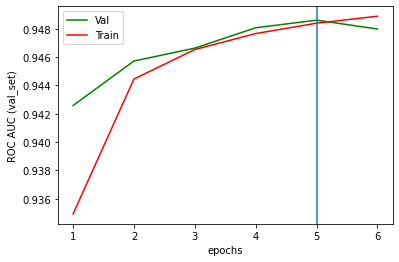

In [31]:
plt.plot(range(1, 7), history.history['val_auc'], "g", range(1, 7), history.history['auc'], "r")
plt.legend(["Val","Train"])
plt.axvline(x=5)
plt.xlabel("epochs")
plt.ylabel("ROC AUC (val_set)")


In [34]:
# evaluation on test set
test = pd.read_csv(config.test_data_path).sample(frac=1)
x_test = test.iloc[:,:2].values
y_test = test.iloc[:,2].values
results = model.evaluate([x_test[:,0], x_test[:,1]], y_test, batch_size=128)
print("test loss, test acc:", results)

13562/13562 [==============================] - 22s 2ms/step - loss: 0.4033 - accuracy: 0.8617 - auc: 0.8707
test loss, test acc: [0.40326255559921265, 0.8617033362388611, 0.8707232475280762]


In [38]:
predictions = model.predict([x_test[:,0], x_test[:,1]])
predictions.shape

(1735935, 1, 1)

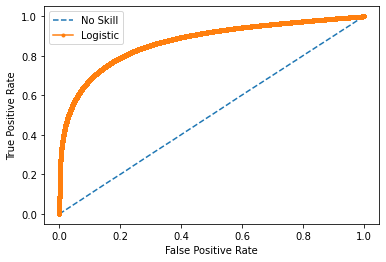

In [40]:
# NOTA BENE: This image may fail to appear in Github. If so, please visit https://nbviewer.jupyter.org/ and copy-paste this jupyter notebook github link. The .png can also be found in folder /results/. 

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, np.random.random(y_test.shape))
lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions.reshape(-1,1))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt the legend
plt.legend()
# show the plot
plt.show()